# Angular Cut Analysis
 
We want to perform an analysis on varying angular cuts of shallow-angled base tracks. Test with muon MC, neutrino MC, and data from Emulsion Target 1 (b000044, cell 8,13). 

First, handle the necessary imports

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn #for regplot, equivalent as tprofile
import fedra2scipy_utils
import numpy as np
import uproot
import awkward as ak
import math

import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

Welcome to JupyROOT 6.26/10
Load FEDRA libs


In [23]:
import matplotlib as mpl

# ensures that ticks are legible on plots generated
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

#### Load Muon MC vertices

In [27]:
m_prepath = '/eos/user/a/aiulian/sim_fedra/muonbkg_1E5cm2_b000011/b000011/vertextree_angle_'
m_nocut_path = '/eos/user/a/aiulian/sim_fedra/muonbkg_1E5cm2_b000011/b000011/vertextree_nocut.root'

In [28]:
mdf_list = []

fname_list = ['001', '003', '005', '01']#, '02', '05', '1', '2']
anglecut_list_sim = [0.001, 0.003, 0.005, 0.01]#, 0.02, 0.05, 0.1, 0.2]
branchnames = ['vID', 'vz', 'flag', 'n', 's/s.eTX', 's/s.eTY', 's/s.eZ', 's/s.ePID', 'nseg', 'npl', 'MCEventID', 'MCTrackID', 'MCTrackPdgCode', 's/s.eID']
# add original file (nocut) to df list
sim_file = uproot.open(m_nocut_path)
sim_tree = sim_file['vtx']
df = sim_tree.arrays(branchnames, library='pd')
df['brickID'] = 11
mdf_list += [df]
# add cut files to df list
for i in range(len(fname_list)):
    sim_file = uproot.open(m_prepath + fname_list[i] + '.root')
    sim_tree = sim_file['vtx']
    df = sim_tree.arrays(branchnames, library='pd')
    df['brickID'] = 11
    mdf_list += [df]

#### Load Neutrino MC vertices

In [29]:
v_prepath = '/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/b000011/vertextree_angle_'
v_nocut_path = '/eos/user/a/aiulian/sim_fedra/nu_sim_activeemu_withcrisfiles_25_July_2022/b000011/vertextree_nocut.root'

In [30]:
vdf_list = []
fname_list = ['001', '003', '005', '01']#, '02', '05', '1', '2']
anglecut_list_sim = [0.001, 0.003, 0.005, 0.01]#, 0.02, 0.05, 0.1, 0.2]
branchnames = ['vID', 'vz', 'flag', 'n', 's/s.eTX', 's/s.eTY', 's/s.eZ', 's/s.ePID', 'nseg', 'npl', 'MCEventID', 'MCTrackID', 'MCTrackPdgCode', 's/s.eID']
# add original file (nocut) to df list
sim_file = uproot.open(v_nocut_path)
sim_tree = sim_file['vtx']
df = sim_tree.arrays(branchnames, library='pd')
df['brickID'] = 11
vdf_list += [df]
# add cut files to df list
for i in range(len(fname_list)):
    sim_file = uproot.open(v_prepath + fname_list[i] + '.root')
    sim_tree = sim_file['vtx']
    df = sim_tree.arrays(branchnames, library='pd')
    df['brickID'] = 11
    vdf_list += [df]

#### Load Run 1 Data vertices

In [31]:
d_prepath = '/eos/user/t/tkrishna/data_vtxfiles/vertextree_ell_'
d_nocut_path = '/eos/user/t/tkrishna/data_vtxfiles/vertextree_nocut.root'

In [32]:
df_list = []

# fname_list = ['001', '003', '005', '01'] for circles
# anglecut_list = [0.001, 0.003, 0.005, 0.01] for circles

fname_list = ['2', '4', '6'] # for ellipse
anglecut_list_data = np.asarray([1.0082142660517188e-05, 4.032857064206875e-05, 9.073928394465467e-05]) # area of ellipses
anglecut_list_data = np.sqrt(anglecut_list_data/math.pi) # effective radius of ellipses
branchnames = ['vID', 'vz', 'flag', 'n', 's/s.eTX', 's/s.eTY', 's/s.eZ', 's/s.ePID', 'nseg', 'npl', 'MCEventID', 'MCTrackID', 'MCTrackPdgCode', 's/s.eID']
# add original file (nocut) to df list
sim_file = uproot.open(d_nocut_path)
sim_tree = sim_file['vtx']
df = sim_tree.arrays(branchnames, library='pd')
df['brickID'] = 11
df_list += [df]
# add cut files to df list
for i in range(len(fname_list)):
    sim_file = uproot.open(d_prepath + fname_list[i] + '.root')
    sim_tree = sim_file['vtx']
    df = sim_tree.arrays(branchnames, library='pd')
    df['brickID'] = 11
    df_list += [df]

#### Get z-values range for the selected brick

In [28]:
m_z = ak.flatten(mdf_list[0]['s/s.eZ'])
v_z = ak.flatten(vdf_list[0]['s/s.eZ'])
print("Muon sim min z:", m_z[ak.flatten(mdf_list[0]['s/s.ePID']==0)][0])
print("Muon sim max z:", m_z[ak.flatten(mdf_list[0]['s/s.ePID']==59)][0])
print("Neutrino sim min z:", v_z[ak.flatten(vdf_list[0]['s/s.ePID']==0)][0])
print("Neutrino sim max z:", v_z[ak.flatten(vdf_list[0]['s/s.ePID']==58)][0])


Muon sim min z: 0.0
Muon sim max z: -77585.0
Neutrino sim min z: 0.0
Neutrino sim max z: -76270.0


In [36]:
d_z = ak.flatten(df_list[0]['s/s.eZ'])
#print("Data min z:", d_z[ak.flatten(df_list[0]['s/s.ePID']==0)][0])
print("Data max z:", d_z[ak.flatten(df_list[0]['s/s.ePID']==56)][0])

Data max z: -74967.796875


## Apply Cuts

Select the good vertices by requiring the vertex to occur within the brick, that the vertex has at least 3 tracks, and that the flag is 0 or 3. Same cuts applied by Fabio.

In [33]:
# cuts on neutrino vertices
def cut_v(vz, n, flag):
    zmin=-76270
    zmax=0
    return [True if (vz[j]<zmax and vz[j]>zmin and n[j]>=3 and (flag[j]==0 or flag[j]==3)) else False for j in range(len(flag))]

for i in range(len(vdf_list)):
    vdf_list[i] = vdf_list[i][cut_v(vdf_list[i]['vz'], vdf_list[i]['n'], vdf_list[i]['flag'])]

In [35]:
# cuts on muon vertices
def cut_m(vz, n, flag):
    zmin=-77585
    zmax=0
    return [True if (vz[j]<zmax and vz[j]>zmin and n[j]>=3 and (flag[j]==0 or flag[j]==3)) else False for j in range(len(flag))]

for i in range(len(mdf_list)):
    mdf_list[i] = mdf_list[i][cut_m(mdf_list[i]['vz'], mdf_list[i]['n'], mdf_list[i]['flag'])]

In [37]:
# cuts on data vertices
def cut_d(vz, n, flag):
    zmin=-74967.796875
    zmax=0
    return [True if (vz[j]<zmax and vz[j]>zmin and n[j]>=3 and (flag[j]==0 or flag[j]==3)) else False for j in range(len(flag))]


for i in range(len(df_list)):
    df_list[i] = df_list[i][cut_d(df_list[i]['vz'], df_list[i]['n'], df_list[i]['flag'])]


## Visualize the Cuts on Base Tracks

0
1
2
3


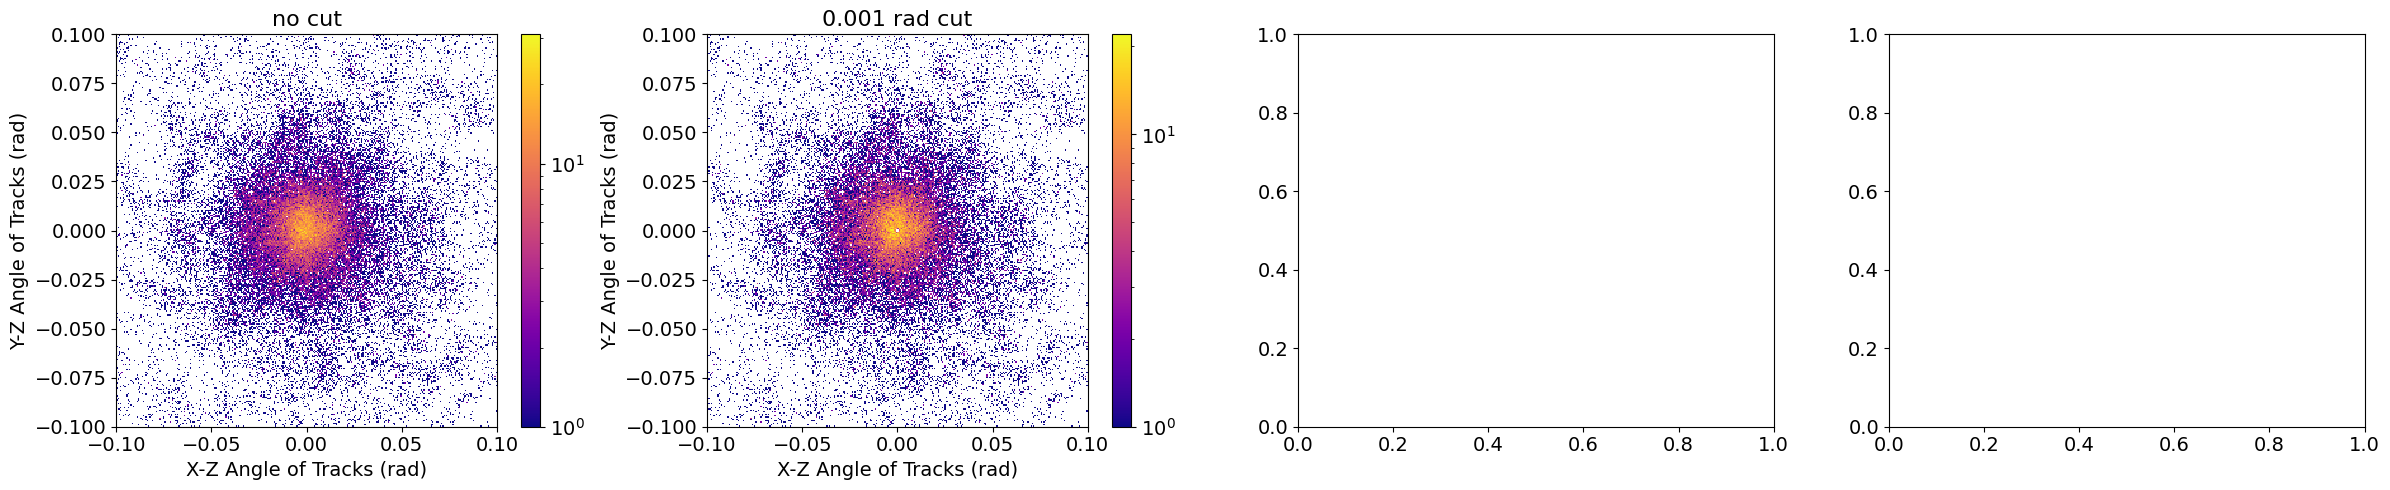

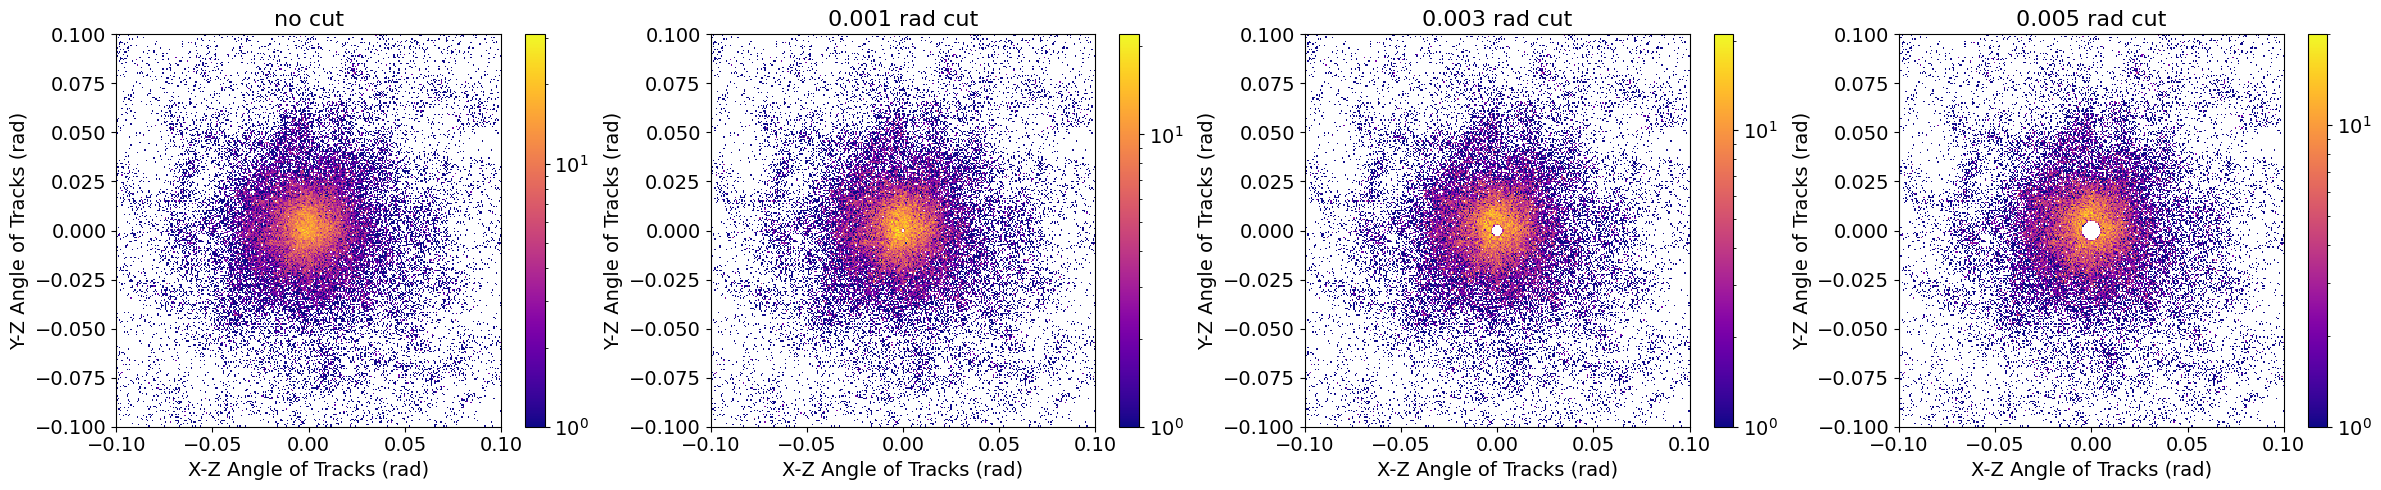

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(24, 5), tight_layout=True)
figarr_idx = [[0,0], [0,1], [0,2], [0, 3]]
thres = 0.1
hist = [0, 0, 0, 0]
range_=((-1*thres, thres), (-1*thres, thres))
for i in range(0, len(figarr_idx)):
    print(i)
    if i==0:
        label="no cut"
    else:
        label = str(anglecut_list_sim[i-1]) + " rad cut"   
    hist[i] = ax[i].hist2d(np.asarray(ak.flatten(vdf_list[i]['s/s.eTX'])), np.asarray(ak.flatten(vdf_list[i]['s/s.eTY'])), bins=300, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
    ax[i].set_title(label, fontsize=16)
    fig.colorbar(hist[i][3], ax=ax[i])
    ax[i].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
    ax[i].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
#plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
#ax.set_ylabel("Vertex Reconstruction Efficiency", fontsize=14)
fig.tight_layout()
plt.savefig("Figures/AngleCuts/muon_angleDist_2dHist_goodVtx_smallAngles.pdf")
plt.show()

0
1
2
3


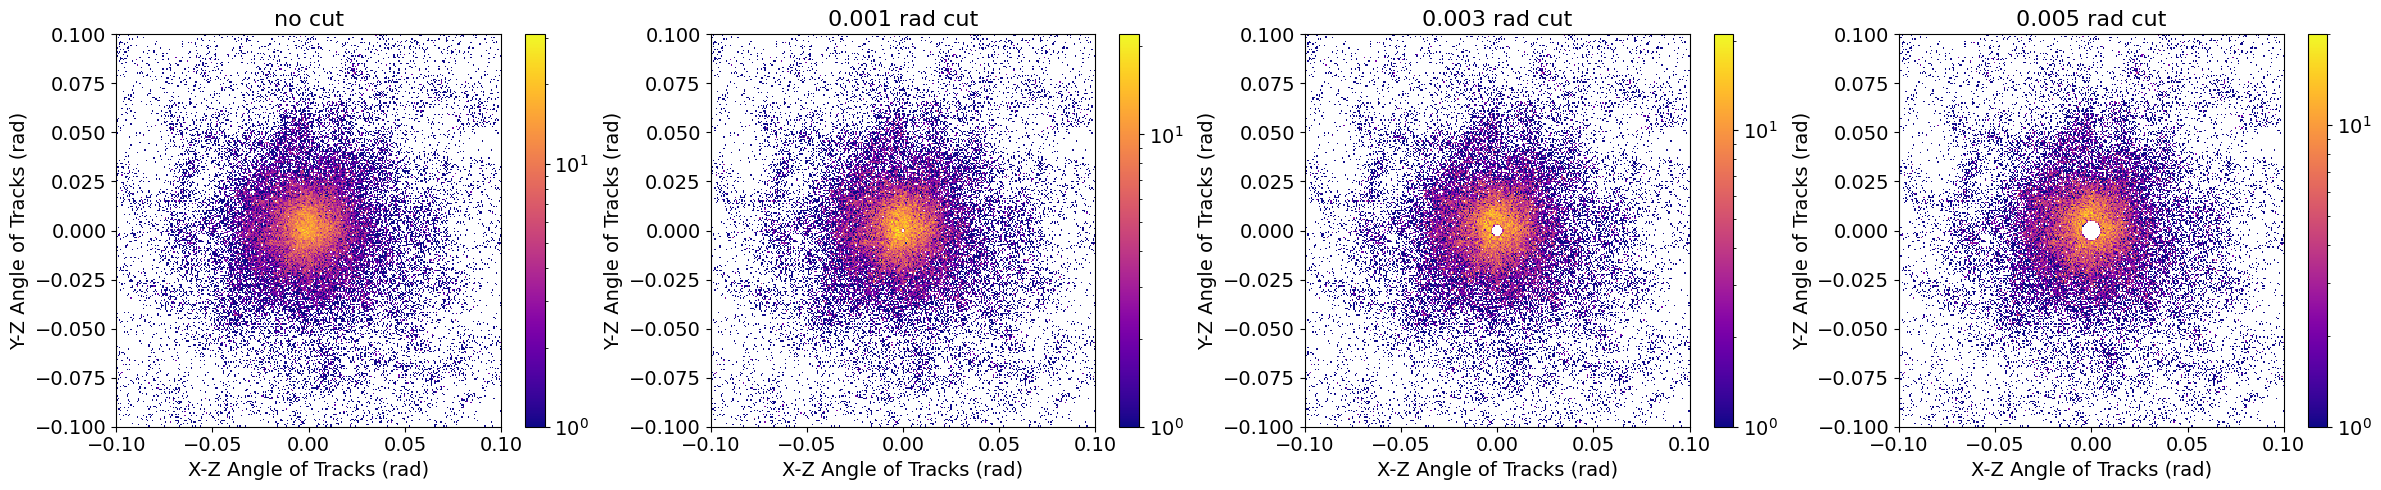

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(24, 5), tight_layout=True)
figarr_idx = [[0,0], [0,1], [0,2], [0, 3]]
thres = 0.1
hist = [0, 0, 0, 0]
range_=((-1*thres, thres), (-1*thres, thres))
for i in range(0, len(figarr_idx)):
    print(i)
    if i==0:
        label="no cut"
    else:
        label = str(anglecut_list_sim[i-1]) + " rad cut"   
    hist[i] = ax[i].hist2d(np.asarray(ak.flatten(vdf_list[i]['s/s.eTX'])), np.asarray(ak.flatten(vdf_list[i]['s/s.eTY'])), bins=300, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
    ax[i].set_title(label, fontsize=16)
    fig.colorbar(hist[i][3], ax=ax[i])
    ax[i].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
    ax[i].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
#plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
#ax.set_ylabel("Vertex Reconstruction Efficiency", fontsize=14)
fig.tight_layout()
plt.savefig("Figures/AngleCuts/neutrino_angleDist_2dHist_goodVtx_smallAngles.pdf")
plt.show()

0
1
2
3


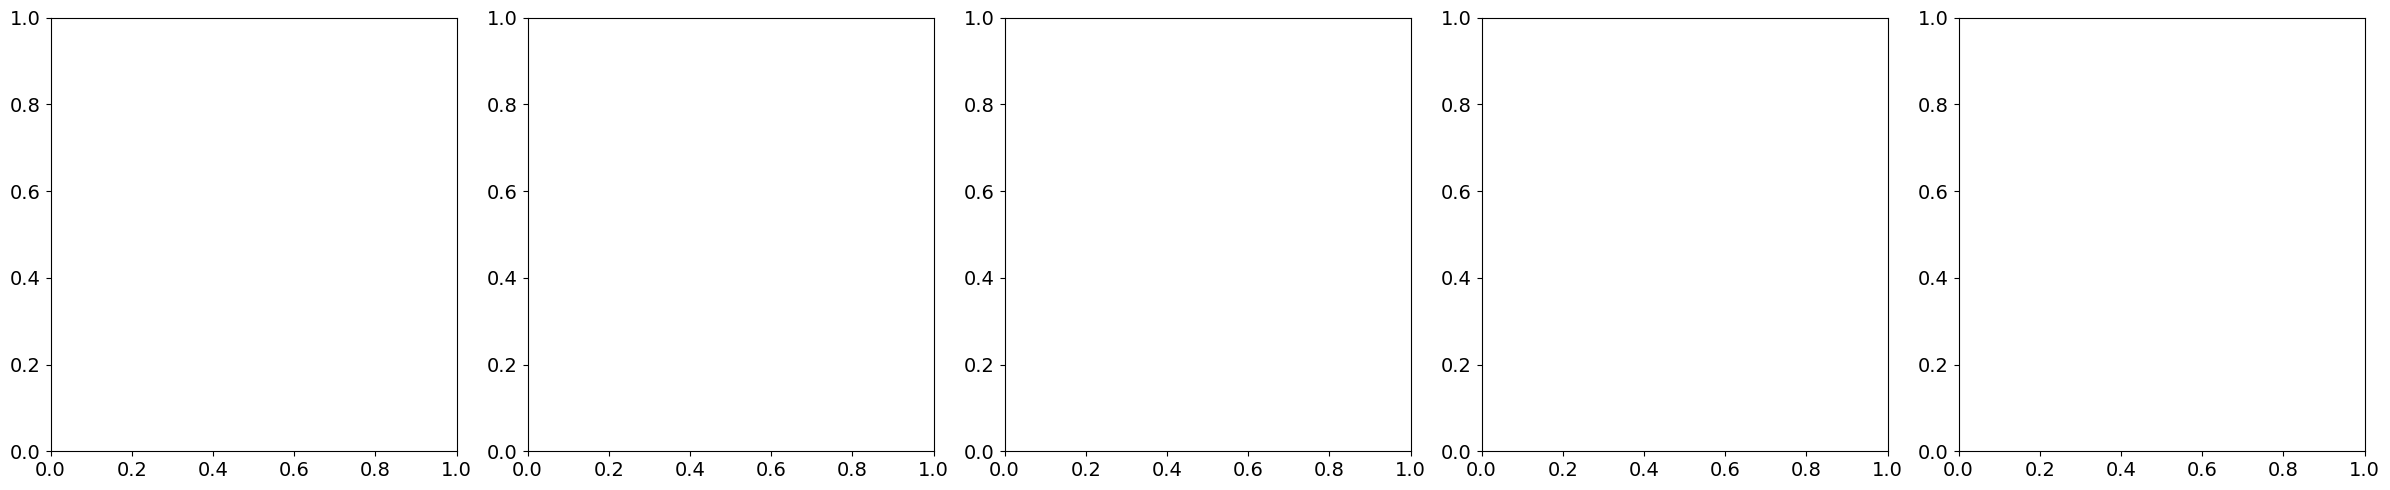

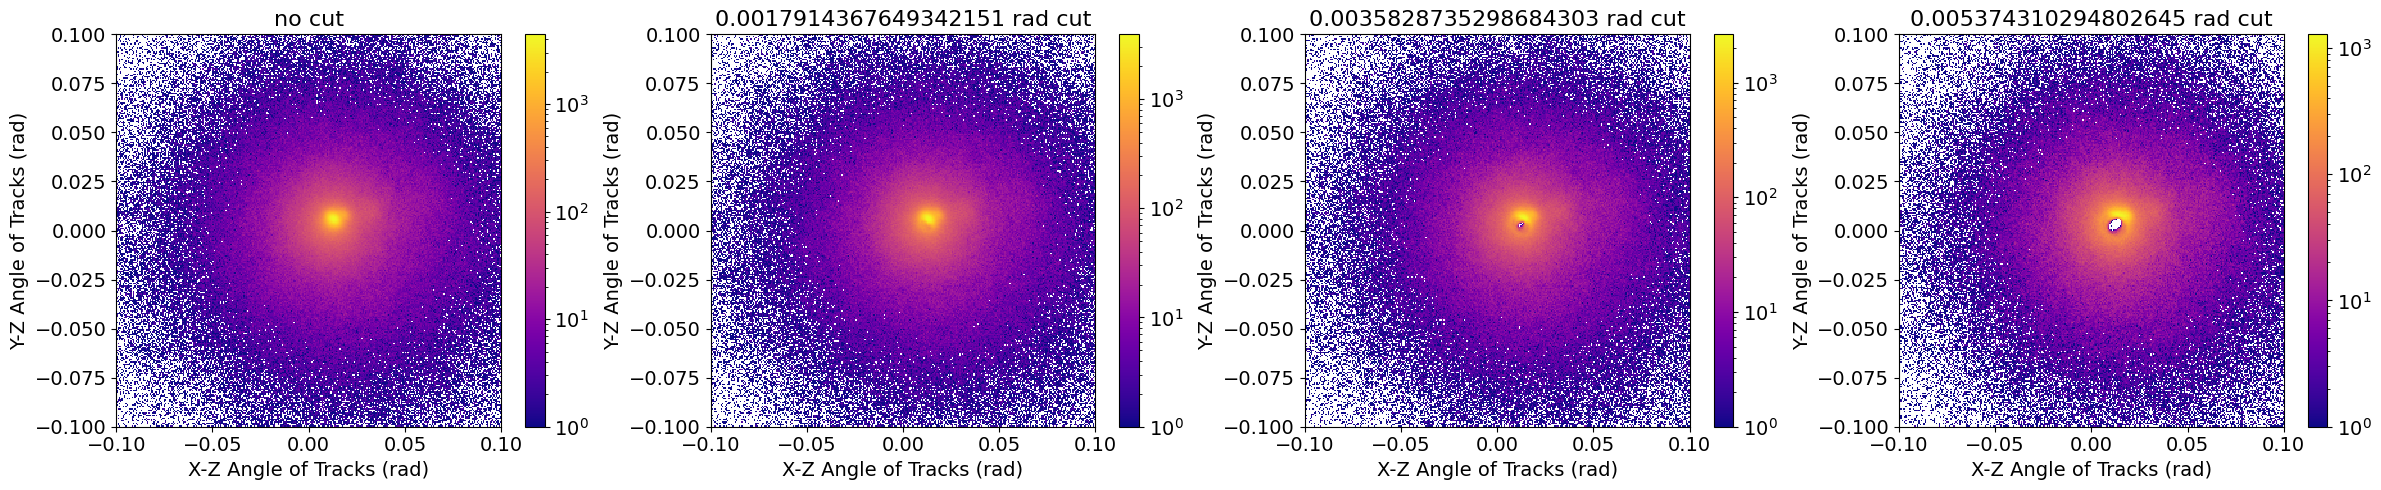

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(24, 5), tight_layout=True)
figarr_idx = [[0,0], [0,1], [0,2], [0, 3]]
thres = 0.1
hist = [0, 0, 0, 0]
range_=((-1*thres, thres), (-1*thres, thres))
for i in range(0, len(figarr_idx)):
    print(i)
    if i==0:
        label="no cut"
    else:
        label = str(anglecut_list_data[i-1]) + " rad cut"   
    hist[i] = ax[i].hist2d(np.asarray(ak.flatten(df_list[i]['s/s.eTX'])), np.asarray(ak.flatten(df_list[i]['s/s.eTY'])), bins=300, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
    ax[i].set_title(label, fontsize=16)
    fig.colorbar(hist[i][3], ax=ax[i])
    ax[i].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=14)
    ax[i].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=14)
#plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
#ax.set_ylabel("Vertex Reconstruction Efficiency", fontsize=14)
fig.tight_layout()
plt.savefig("Figures/AngleCuts/data_angleDist_2dHist_goodVtx_smallAngles.pdf")
plt.show()

### Distributions without Cuts

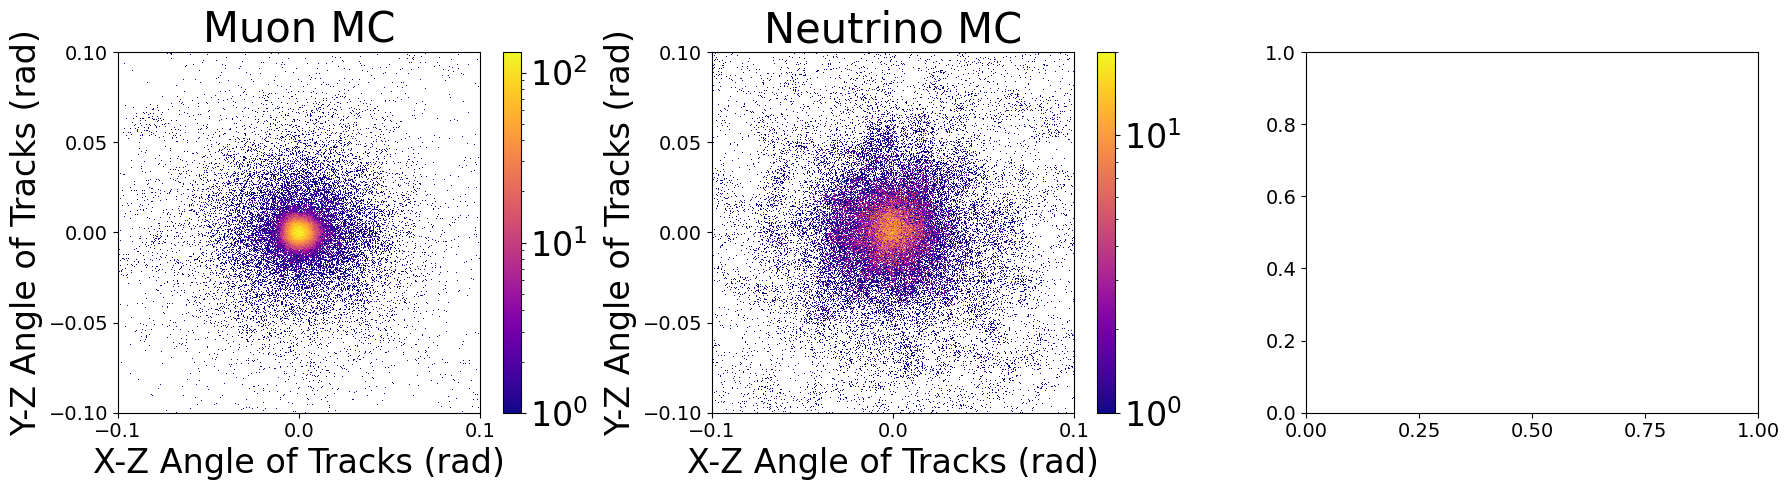

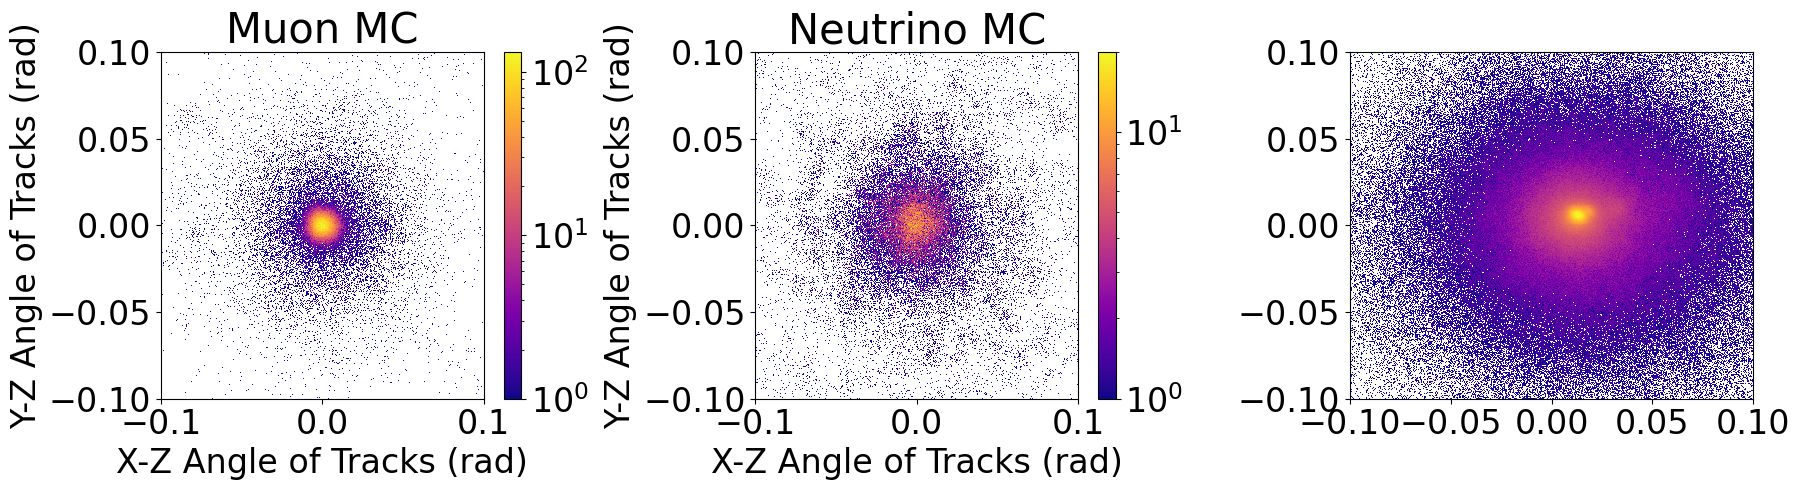

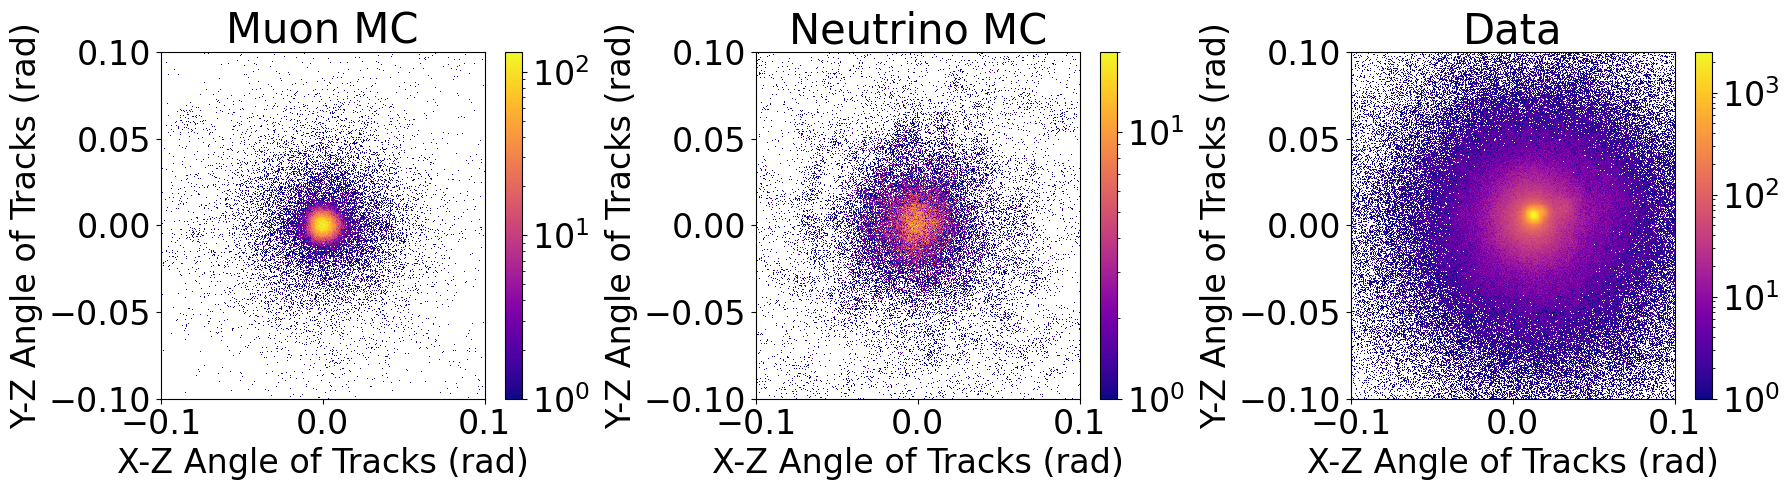

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), tight_layout=True)
mpl.rc('xtick', labelsize=24) 
mpl.rc('ytick', labelsize=24) 
thres = 0.1
hist = [0, 0, 0]
range_=((-1*thres, thres), (-1*thres, thres))

sel = 0
hist[0] = ax[0].hist2d(np.asarray(ak.flatten(mdf_list[sel]['s/s.eTX'])), np.asarray(ak.flatten(mdf_list[sel]['s/s.eTY'])), bins=400, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
ax[0].set_title("Muon MC", fontsize=30)
fig.colorbar(hist[0][3], ax=ax[0])
ax[0].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=24)
ax[0].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=24)

hist[1] = ax[1].hist2d(np.asarray(ak.flatten(vdf_list[sel]['s/s.eTX'])), np.asarray(ak.flatten(vdf_list[sel]['s/s.eTY'])), bins=400, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
ax[1].set_title("Neutrino MC", fontsize=30)
fig.colorbar(hist[1][3], ax=ax[1])
ax[1].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=24)
ax[1].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=24)

hist[2] = ax[2].hist2d(np.asarray(ak.flatten(df_list[sel]['s/s.eTX'])), np.asarray(ak.flatten(df_list[sel]['s/s.eTY'])), bins=400, cmap=mpl.colormaps['plasma'], norm= mpl.colors.LogNorm(), range=range_)
ax[2].set_title("Data", fontsize=30)
fig.colorbar(hist[2][3], ax=ax[2])
ax[2].set_xlabel("X-Z Angle of Tracks (rad)", fontsize=24)
ax[2].set_ylabel("Y-Z Angle of Tracks (rad)", fontsize=24)

fig.tight_layout()
plt.savefig("Figures/AngleCuts/example_angleDist_2dHist_goodVtx_smallAngles_"+str(sel)+".pdf")
plt.show()

## Compare number of vertices 

First we'll look at the ratio between the number of vertices reconstructed when a cut is applied compared to without cuts. This is not an efficiency - this is simply a comparison between the number of vertices reconstructed with no angular cuts applied, and with the selected angular cuts.

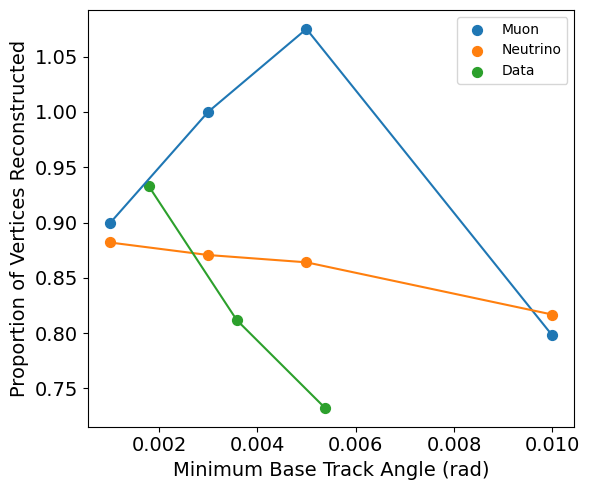

In [38]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)

# for each of the MC cut values, plot the ratio between # of vertices reconstructed and # reconstructed without any cuts
for i in range(len(anglecut_list_sim)):
    dot1 = ax.scatter(anglecut_list_sim[i], len(mdf_list[i+1])/len(mdf_list[0]), s=50, color='tab:blue')
    dot2 = ax.scatter(anglecut_list_sim[i], len(vdf_list[i+1])/len(vdf_list[0]), s=50, color='tab:orange')
ax.plot(anglecut_list_sim, [len(mdf_list[i+1])/len(mdf_list[0]) for i in range(0, len(anglecut_list_sim))], color='tab:blue')
ax.plot(anglecut_list_sim, [len(vdf_list[i+1])/len(vdf_list[0]) for i in range(0, len(anglecut_list_sim))], color='tab:orange')

# repeat this for the data as well, for each of its cut values
for i in range(len(anglecut_list_data)):  
    dot3 = ax.scatter(anglecut_list_data[i], len(df_list[i+1])/len(df_list[0]), s=50, color='tab:green')
ax.plot(anglecut_list_data, [len(df_list[i+1])/len(df_list[0]) for i in range(0, len(anglecut_list_data))], color='tab:green')

ax.legend([dot1, dot2, dot3], ['Muon', 'Neutrino', 'Data'])
plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Proportion of Vertices Reconstructed", fontsize=14)
plt.savefig("Figures/AngleCuts/vtxFrac_scatter_smallAngle_goodVtx_withEllData.pdf")
plt.show()

We will also look at the ratio between neutrinos and muons in proportion of reconstructed vertices under each of the cuts compared to no-cut. This allows us to see which ratio will maximize signal-to-background vertex reconstruction. 

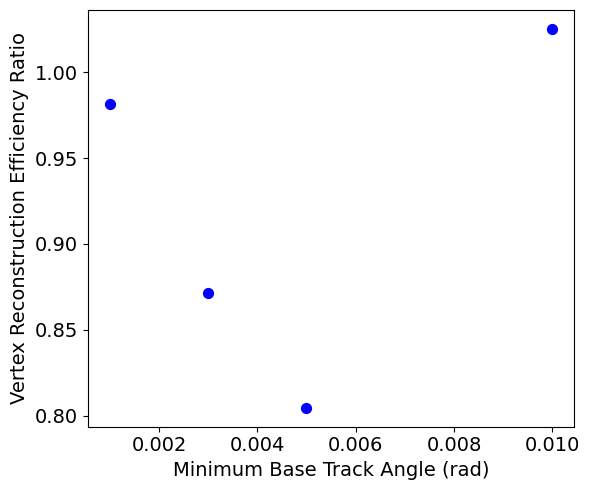

In [183]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)

for i in range(len(anglecut_list)):
    vtx_frac_ratio = (len(vdf_list[i+1])/len(vdf_list[0]))/(len(mdf_list[i+1])/len(mdf_list[0]))
    dot1 = ax.scatter(anglecut_list_sim[i], vtx_frac_ratio, s=50, color='b')

plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Vertex Reconstruction Efficiency Ratio", fontsize=14)
plt.savefig("Figures/AngleCuts/vtxFrac_ratio_scatter_smallAngle_goodVtx.pdf")
plt.show()

## Comparing Number of Base Tracks

First we use the s/s.eTX arrays to count the number of base tracks. Each vertex consists of base tracks, which each have their own s/s.eTX value.

In [39]:
numm = [len(ak.flatten(mdf_list[i]['s/s.eTX'])) for i in range(len(mdf_list))]
numv = [len(ak.flatten(vdf_list[i]['s/s.eTX'])) for i in range(len(vdf_list))]
numd = [len(ak.flatten(df_list[i]['s/s.eTX'])) for i in range(len(df_list))]

We'll look at the ratio between the number of base tracks reconstructed when a cut is applied compared to without cuts. This is not an efficiency - this is simply a comparison between the number of base tracks reconstructed with no angular cuts applied, and with the selected angular cuts. The neutrino and muon MC base tracks are base tracks that result from a simulated muon or neutrino interaction.

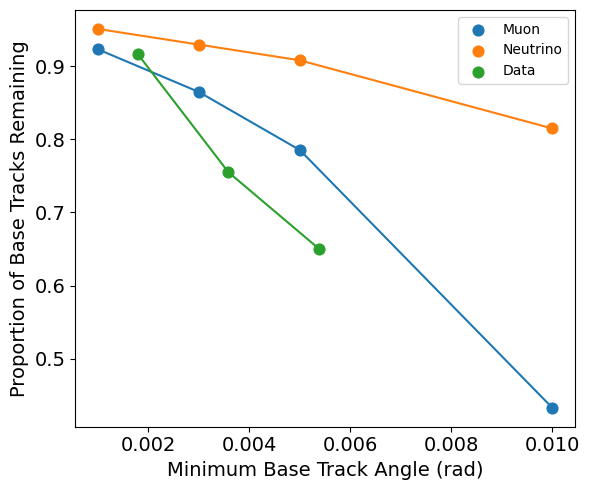

In [40]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)
for i in range(len(anglecut_list_sim)):
    dot1 = ax.scatter(anglecut_list_sim[i], numm[i+1]/numm[0], s=60, color='tab:blue')
    dot2 = ax.scatter(anglecut_list_sim[i], numv[i+1]/numv[0], s=60, color='tab:orange')
ax.plot(anglecut_list_sim, [numm[i+1]/numm[0] for i in range(0, len(anglecut_list_sim))], color='tab:blue')
ax.plot(anglecut_list_sim, [numv[i+1]/numv[0] for i in range(0, len(anglecut_list_sim))], color='tab:orange')

    
for i in range(len(anglecut_list_data)):
    dot3 = ax.scatter(anglecut_list_data[i], numd[i+1]/numd[0], s=60, color='tab:green')
ax.plot(anglecut_list_data, [numd[i+1]/numd[0] for i in range(0, len(anglecut_list_data))], color='tab:green')

ax.legend([dot1, dot2, dot3], ['Muon', 'Neutrino', 'Data'])
ax.set_xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Proportion of Base Tracks Remaining", fontsize=14)
plt.savefig("Figures/AngleCuts/segFrac_scatter_smallAngle_goodVtx_withEllData.pdf")
plt.show()

We will also look at the ratio between neutrinos and muons in proportion of reconstructed base tracks under each of the cuts compared to no-cut. This allows us to see which ratio will maximize signal-to-background base track reconstruction. 

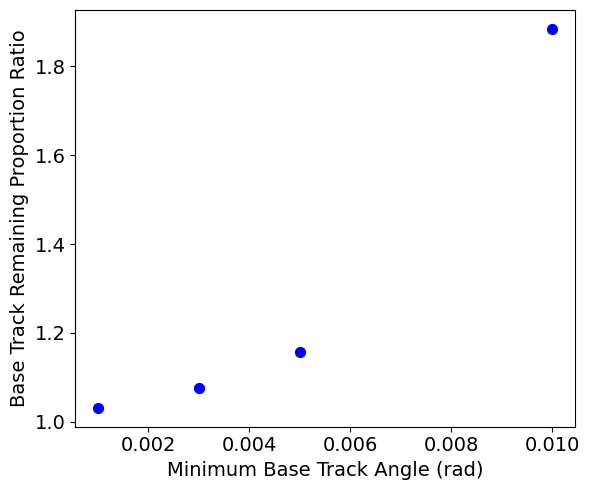

In [200]:
fig, ax = plt.subplots(1, figsize=(6, 5), tight_layout=True)
for i in range(len(anglecut_list)):
    seg_frac_ratio = (numv[i+1]/numv[0])/(numm[i+1]/numm[0])
    dot1 = ax.scatter(anglecut_list[i], seg_frac_ratio, s=50, color='b')

plt.xlabel("Minimum Base Track Angle (rad)", fontsize=14)
ax.set_ylabel("Base Track Remaining Proportion Ratio", fontsize=14)
plt.savefig("Figures/AngleCuts/segFrac_ratio_scatter_smallAngle_goodVtx.pdf")
plt.show()